
---

# MNISTを使った数字認識
今回は，「MNIST 手書きデータセット」と呼ばれる学習データを利用します．  
問題としては，
- 「手書きで書かれた0〜9の間の数字」が入力された時に，「手書きで書かれた数字の正しい分類結果」を出力

するように学習することが目的となります．    

<br>

前章までと比較して
- 画像データを扱う

部分が大きく異なります．

<br>

手書き数字の画像データがどのような形式で表現されているかを下図に示します．

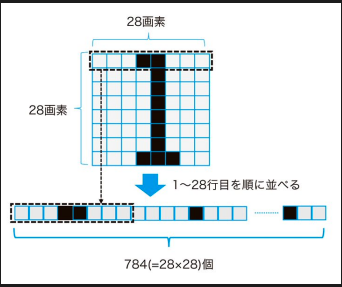



特徴としては以下のようになります．
- 画像データは縦，横それぞれ28画素
- 画素ごとの色の濃淡は0から255
    - ただし，Pytorchライブラリ経由で取得する場合[0, 1]の範囲の浮動小数点表現に正規化されます．
- Pytorchで取得する場合，このデータは[1, 28, 28]の3階のテンソルになります．
    - これは[チャンネル数，x方向の長さ, y方向の長さ]という意味です．（チャンネル数：今回は白黒画像なので１チャンネルになります．RGB画像なら3チャンネルです）
- 今回は，「全結合型ニューラルネットワーク」を使用するため，上図のように28×28の画像を748(=28×28)の要素を持った1次元配列に変更したものを入力とします．
- 数字は0〜9の10種類あるため，分類先のクラス数は10個になります．


<br>

本章のモデルは，下図のように線形関数が2段階になっています．これは，いわゆる「隠れ層あり」のモデルであることを意味します．

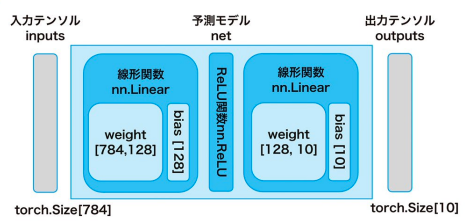

<br>

以上をまとめると，今回作成するモデルは
- 「入力784次元，出力10次元，隠れ層あり」のニューラルネットワーク

ということになります．



---


# ニューラルネットワークとディープラーニング
ディープラーニングは下図のように，線形関数が2階層以上のモデルのことを言います．  

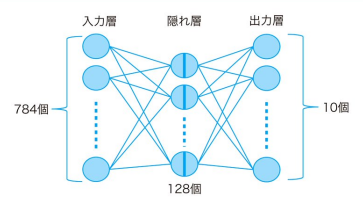


---

## 活性化関数とReLU関数
最初に，注意しておきたい点として，階層の深いニューラルネットワークについては
- 単なる線形関数の結果を次の隠れ層の入力にするだけでは，いくら層を深くしても1階層のモデルと数学的に変わらない

ということが分かっています．

<br>

そこで，階層の深いニューラルネットワークでは「非線形関数」と呼ばれる関数を作用させる必要があります．
この関数は，機械学習の世界では活性化関数と呼ばれ，本章では
- ReLU関数

を利用します．

<br>

ReLU関数のグラフを下記コードで確認してみましょう．  
特徴として，
  - ReLU関数では，x<0の時には0，x=>0では，y=xの1次関数を出力

するといった関数になります．  
これは，非常にシンプルですが，x=0で別の関数に切り替わるため，結果的に「**非線形関数**」の1つとなり**ディープラーニング用の活性化関数として意味を持つ**ことになります． 

In [ ]:
!pip install japanize_matplotlib | tail -n 1

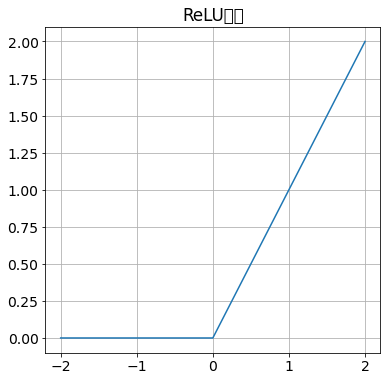

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import torch
# warning表示off
import warnings
warnings.simplefilter('ignore')
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

# ReLU関数のグラフ
relu = torch.nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()


---

## GPUの利用

本章で使用するモデルは，前章までに比べて計算量が多くCPUでは処理に時間がかかり過ぎてしまうため，ここからはGPUを利用して学習を行います．  
Pytorchでは，プログラムで自動的にGPUが「利用されない」ので注意する必要があります．

<br>

まず，google colablatoryの現在のランタイムが「GPU」に設定されていることを確認してください．  
確認ができたら，以下のコードで，GPUの存在をチェックします．

`cuda:0`と出力されれば，GPUが正しく認識されています．逆に，`cpu`と表示されている場合は，GPUが認識されていないので，ランタイムの設定を確認してみてください．

In [ ]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<br>

PytorchでGPUを利用する際のルールとして以下のようなものがあります．
- テンソル変数はデータがCPU/GPU上のどちらにあるのかを属性として持っています
- CPUとGPU間でデータはto関数で転送します
- 2つの変数の両方ともがGPU上にある場合，演算はGPUで行われます
- 変数の片方がCPU,もう片方がGPUの場合，演算はエラーとなります

以下のコードではCPUで演算されていることになります．

In [ ]:
# テスト用テンソル変数x,y
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# xとyの間の演算
z = x*y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


次に，テンソル変数をGPUに送ってみましょう．  
テンソル変数は
- to関数を利用することで，CPU->GPU，GPU->CPUに転送

することができます．  
また，テンソル変数はdevice属性を持っており，これによりCPU/GPUのどちらに所属しているかを確認することができます．  

<br>

まずは，`x`のみをGPUに送って見ましょう．


In [ ]:
# 変数xをGPUへ
x = x.to(device)

# 変数xとyのdevice属性の確認
print("x: ", x.device)
print("y: ", y.device)

<br>

現在の状態では，`x`のみがGPU側に転送されており，`y`はCPU側に残っています．  
この状態で，`z=x+y` のような演算をするとエラーが起こってしまいます．  
そのため，`y`もGPU側に送ってから演算を行いましょう．

In [ ]:
# yもGPUへ
y = y.to(device)

z = x*y
print(z)

<br>

モデルのインスタンス（前章までで，`net`としていたもの）についてもGPUに所属しているかどうかを意識する必要があります．  
理由としては，「モデルの内部には線形関数などのインスタンスが含まれており，そこにはインスタンス変数があるため」です．  

例として，以下のように記述することでモデルのインスタンスをGPU側に送ることができます．  
```
net = Net(n_input, n_output, n_hidden).to(device)
```



---

## データ前処理
ここでは，学習データをモデルに入力する前に加工を行います．これはデータ前処理と呼ばれます．  
データ前処理の例としては，以下のようなものがあります．
- 値の範囲の変更：[0,1]の範囲を[-1,1]の範囲へ変更
- 次元の変更：1件のデータが[1,28,28]の3階テンソルを[784]の1階テンソルへ変更

Pytorchには前処理に必要な便利な関数が揃っているため，これらを活用することでデータの変換が可能になります．



---

## ミニバッチ学習

今回は，学習するデータが6万件もあるため，全件をまとめて勾配計算すると，1回の処理に時間がかかりすぎるため効率が悪くなってしまいます．（ちなみに，全件まとめて勾配を計算する方法は「バッチ学習」と呼ばれます．）  

そこで，
- グループ単位で勾配を計算する方法

である「ミニバッチ学習」を行います．  
また，ミニバッチ学習はグループを選ぶ際に乱数を使用することで，繰り返し処理ごとに別のグループができるので，
- 勾配降下法における局所最適解に陥ることを避けることができる

といったメリットも存在します．  

<br>

Pytorchでは，このミニバッチ学習を簡単に行えるデータローダーという仕組みが用意されています．






---

## データ準備1（データセットによる読み込み）
Pytorchには，データ準備のための道具が豊富で
- データ入手には「Dataset」
- データ加工には「transforms」
- ミニバッチ用データ生成には「DataLoader」

など様々な専用のクラスが用意されています．

<br>

最初に，Datasetクラスのインスタンスの1つである  `datasets.MNIST` を利用して，MNISTのデータセットを読み込みます．

In [ ]:
!pip install torchviz | tail -n 1

In [ ]:
# ライブラリのインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = "./data"

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,
    # 訓練データか検証データか
    train = True,
    # 元データがない場合に，ダウンロードするかどうか
    download = True
)

In [ ]:
# ダウンロードしたファイルの確認
! ls -lR ./data/MNIST

<br>

読み込んだデータセット`train_set0`はPythonのリストとして「入力データ，正解データ」のセットを順に取得できます．

In [ ]:
print("データ件数: ", len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

print("入力データの型：", type(image))
print("正解データの型：", type(label))


# 最初の要素の確認 ------------
plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()


---

## データ準備2（Transformsによるデータ前処理）

ここでは，以下の3つのデータ前処理をTransformsを用いて行います．
- データのテンソル化
- データの正規化
- データの1次元化

<br>

なお，データの正規化は$Normalize(\mu, \sigma)$により，元のデータ$x$は$X=(x-\mu)/\sigma$に変換されます．
- 下コードのように．$\mu=\sigma=0.5$とすると，[0,1]の範囲の値$x$を[-1,1]の範囲の値$X$に変換可能です．

In [ ]:
import torchvision.transforms as transforms
# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

# transforms.Composeを利用することで，複数の処理を組み合わせたtransformsを作成可能
transform = transforms.Compose([
    # (1) データのテンソル化(テンソル変数に変換，この時点では，shapeは[1,28,28]，最小値が0，最大値が1になっている)
    transforms.ToTensor(),
    
    # (2) データの正規化(データの正規化を[0,1]から[-1,1]に変更)
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1階テンソルに変換（shapeを[1,28,28]から[784]に変更）
    transforms.Lambda(lambda x: x.view(-1)),
])

<br>

これで，transformsによるデータ変換の準備ができたので，この設定をもとにデータセットを作成します．

In [ ]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

上記のような考え方を拡張すれば，データセットに独自のクラスを定義することも可能です． 

**オブジェクト指向の考えをうまく取り入れて，機械学習モデル構築における2大タスクである「データ準備」と「モデル構築」をきれいに切り分けることが可能になります．**


---

# データ準備3（データローダーによるミニバッチ用データ生成）
データ準備の最終タスクとしてミニバッチ処理の準備を行います．  

このタスクでは，PyTorchのデータローダー（DataLoader）というクラスを利用します．

In [ ]:
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので，シャッフルする
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True
)

# 検証用データ
# 検証用にシャッフルは不要
test_loader = DataLoader(
    test_set, batch_size = batch_size, 
    shuffle = False
)

# データローダーのテスト ---------------------
# データローダーではlen関数で何組のデータが取れるか確認してみます
# 以下を実行すると，120は60000/500の結果と一致していることが分かります．

# 何組のデータが取得できるか
print(len(train_loader))

# データローダーから最初のセットを取得
for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)


---

## モデル定義
モデルの定義を行います．  
前章までと異なる点は以下の通りです．
- 隠れ層が存在するため，隠れ層のノード数も定義します（今回の場合は128に設定）．
- 線形関数(`nn.Linear`）が1つから2つに増加しています．
- ReLU関数が追加されています．
    - なお，2層目（出力層）の線形関数の出力に対しては活性化関数がありませんが，これは前章と同様に「損失関数側にsoftmax関数が組み込まれているため」です．
- パラメータを1.0にする設定がなくなっています．これは，モデルのパラメータが増大したことにより，1.0に統一するとうまく学習できないためです．
    - このため，初期設定である「乱数を使った初期化」に変更されています．

In [ ]:
# 入力，出力次元数の定義 --------------------------------------
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス　今回は10
n_output = len(set(list(labels.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

print(f"n_input: {n_input} n_hidden: {n_hidden} n_output: {n_output}")


# モデルの定義 --------------------------------------
# 784入力　10出力　1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
  def __init__(self, n_input, n_output, n_hidden):
    super().__init__()

    # 隠れ層の定義
    self.l1 = torch.nn.Linear(n_input, n_hidden)

    # 出力層の定義
    self.l2 = torch.nn.Linear(n_hidden, n_output)

    # ReLU関数の定義
    self.relu = torch.nn.ReLU(inplace = True)

  def forward(self, x):
    x1 = self.l1(x)
    x2 = self.relu(x1)
    x3 = self.l2(x2)
    return x3


# モデルのインスタンス化 --------------------------------------
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデル変数の生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

# 最適化アルゴリズムと損失関数の定義 ----------------------------------
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

<br>

ここで，モデル内のパラメータを確認してみると
- 前章までは，変数がl1.weightとl1.biasの2つだったが，l2.weightとl2.biasが増えており，
- device='cuda:0'の表示がある

ということが分かります．

In [ ]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
  print(parameter)


---

# 学習

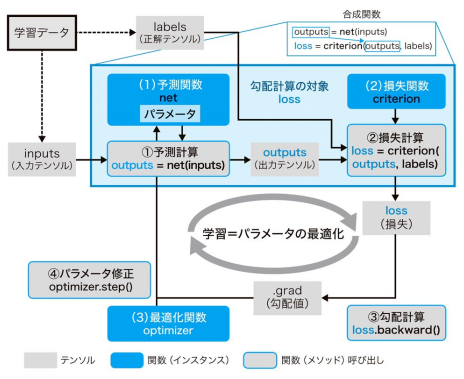


これまでの説明を元に繰り返し処理（学習）を行います．  
変更点としては，以下の通りになります
- ミニバッチ処理でも繰り返し計算が入ることで2重の繰り返しループになっています．
    - これにより，データローダから楽手データを取り出すたびにデータをGPUに送る処理が必要になっています．
- 訓練フェーズでミニバッチ処理ようにループを回す際に，tqdm関数を経由しています．
  ```
  rom tqdm.notebook import tqdm
  for inputs, labels in tqdm(train_loader):
  ```  
  これは，必須ではありませんが，プログレスバーが表示されることになり，学習の進行具合が分かりやすく可視化することができます．

In [ ]:
import torch.optim as optim

# 準備 --------------------------------------------
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

# 繰り返し処理 ----------------------------------------------
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))


---

## 結果確認
学習曲線より学習結果を確認して見ましょう．

In [ ]:
#損失と精度の確認 -------------------------------
print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

# 学習曲線の表示 (損失) -----------------------
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

# 学習曲線の表示 (精度) -----------------------
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

<br>

実際にどの程度正しく認識できているかも確認して見ましょう．

In [ ]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

In [ ]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


---

## 補足：勾配消失とReLU関数
シグモイド関数では，入力値が0から離れていると，傾き（＝勾配値）は0に近づきます．  

学習は勾配値に基づいて行われるので，勾配が0に近づくと学習は極めて困難になってしまいます  

これが **「ディープラーニングの勾配消失問題」の本質**となります．  

一方で，ReLU関数では入力値がプラスでさえあれば，xの値によらず勾配値は常に一定となる．すなわち，**勾配消失が起きにくい**ということになります．  

ディープラーニングの急速な発展の1つに「**ReLU関数の発見**」があったことは確かです．



---

## 補足　ラムダ式による関数定義
ラムダ式による関数定義の前に，def文による通常の関数定義の方法を復習しましょう．  

defによる2次関数は以下のように定義されます．

In [ ]:
# 通常の関数定義
def f(x):
  return (2 * x**2 + 2)

また，関数を呼び出すときは下記のようになります．

In [ ]:
x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)

<br>  
次に，ラムダ式で同様のコードを実装して見ます．

In [ ]:
# ラムダ関数による関数定義

g = lambda x: 2* x**2 + 2

このように定義した関数gもf(x)と同様に，下記コードで呼び出し可能です．

In [ ]:
y = g(x)
print(y)

<br>  

ここで，先ほどのlambda式を使用して，1階テンソル化を行った箇所を再度確認してみます．  
```
transform = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # Tensorの1階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download=True, transform = transform)
```
<br>  

Lambdaクラスは**引数として関数を取るので**上記コードを普通の関数定義の方法で実現すると  
```
def f(x):
  return x.view(-1)
```
となり，
```
transforms.Lambda(f)
```
のようにして，定義した関数f(x)を，fだけ引数にする形でLambdaに渡します．  
このように，「関数定義」と「Lambdaクラスの呼び出し」の2ステップが必要になってしまいます．  
<br>

一方で，
```
transforms.Lambda(lambda x: x.view(-1)),
```
のように定義すると，Lambdaクラスの呼び出し時にまとめて，関数定義までできます．  

ラムダ方式では関数に名前を付けることをしなくても済む（この使い方を**無名関数**と呼ぶ）のでよりスマートなコードを記述することが可能となります（fという関数はここでしか使わないので，fという名前を定義することすら無駄）



---


# 補足：バッチサイズと精度の関係
ミニバッチ学習法において，今回の例では「バッチサイズを小さくした方が，精度が良くなる」という結果になります．  

その結果を下図に示す  
図を見ればわかるように，バッチサイズが大きく影響していることが分かると思います．  

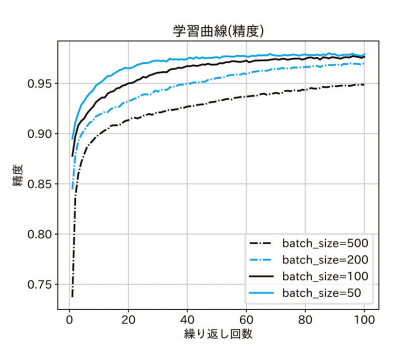

